<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 5: Pretraining on Unlabeled Data

In [27]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.4
numpy version: 1.26.4
tiktoken version: 0.8.0
torch version: 2.5.0+cu118
tensorflow version: 2.18.0


本章内容包括
- 计算训练和验证集的损失，以评估在训练期间生成的LLM文本的质量
- 实现一个训练函数并预训练LLM
- 保存和加载模型权重以继续训练LLM
- 从OpenAI加载预训练的权重

在前几章中，我们实现了数据采样、注意力机制并编码了LLM架构。本章的核心重点是实现一个训练函数并预训练LLM。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/chapter-overview.webp" width=500px>

- 本章涵盖的主题如下所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model--0.webp" width=400px>

## 5.1 Evaluating generative text models

- 我们首先简要回顾一下如何使用前一章的代码来初始化一个GPT模型
- 接着，我们讨论了用于评估大型语言模型的基本评价指标
- 最后，在本节中，我们将这些评价指标应用于训练集和验证集

### 5.1.1 Using GPT to generate text

- 我们使用前一章的代码来初始化一个GPT模型

In [29]:
import torch                        # 导入torch库
from previous_chapters import GPTModel      # 从第4章导入GPTModel

GPT_CONFIG_124M = {                 # GPT配置字典
    "vocab_size": 50257,            # 词汇表大小
    "context_length": 256,          #A 将上下文长度从1024缩短到256词元
    "emb_dim": 768,                 # 嵌入维度
    "n_heads": 12,                  # 注意力头数量
    "n_layers": 12,                 # 层数
    "drop_rate": 0.1,               #B 可能且常见的是将dropout设置为0。
    "qkv_bias": False               # QKV偏置
}

torch.manual_seed(123)              # 设置随机种子
model = GPTModel(GPT_CONFIG_124M)   # 使用配置初始化模型
model.eval()                        # 将模型设置为评估模式

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- 我们之前使用了0.1的dropout（随机失活率），但现在训练大型语言模型时不使用dropout已经相对常见了。
- 现代的大型语言模型在`nn.Linear`层中用于查询（query）、键（key）和值（value）矩阵时也不使用偏置向量（这与早期的GPT模型不同），这是通过设置`"qkv_bias": False`来实现的。
- 我们将上下文长度（`context_length`）减少到只有256个令牌，以降低训练模型所需的计算资源需求，而原始的具有1.24亿参数的GPT-2模型使用了1024个令牌。
  - 这样做是为了让更多读者能够在他们的笔记本电脑上跟随并执行代码示例。
  - 我们稍后也会从预训练权重中加载一个具有1024个令牌`context_length`（上下文长度）的模型。

- 接下来，我们使用前一章中的 `generate_text_simple`函数来生成文本。
- 此外，我们定义了两个实用函数，`text_to_token_ids` 和 `token_ids_to_text`，用于在本章中使用的令牌（token）和文本（text）表示之间的转换。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp" width=500px>

In [31]:
import tiktoken                    # 导入tiktoken库
from previous_chapters import generate_text_simple # 从第4章导入generate_text_simple函数

def text_to_token_ids(text, tokenizer):   # 定义text_to_token_ids函数
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'}) # 编码文本，允许特殊词元
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 添加批次维度
    return encoded_tensor             # 返回编码后的张量

def token_ids_to_text(token_ids, tokenizer): # 定义token_ids_to_text函数
    flat = token_ids.squeeze(0)       # 移除批次维度
    return tokenizer.decode(flat.tolist()) # 解码为文本

start_context = "Every effort moves you" # 设置初始上下文
tokenizer = tiktoken.get_encoding("gpt2") # 获取GPT-2的分词器编码

token_ids = generate_text_simple(   # 调用generate_text_simple函数生成词元ID
    model=model,                    # 模型
    idx=text_to_token_ids(start_context, tokenizer), # 将初始上下文转换为词元ID
    max_new_tokens=10,              # 最大新词元数
    context_size=GPT_CONFIG_124M["context_length"]  # 上下文长度
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer)) # 打印生成的文本


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 根据输出结果，很明显模型尚未生成连贯的文本，因为它还没有经过训练。
- 要定义使文本 “连贯”或“高质量” 的标准，我们必须实现一种数值方法来评估生成的内容。这种方法将使我们能够在整个训练过程中监控和提高模型的性能。
- 接下来的小节介绍了用于计算生成输出的损失度量的指标，我们可以使用这些指标来衡量训练进度。
- 接下来的章节关于微调大型语言模型也会介绍额外的方法来衡量模型质量。

### 5.1.2 Calculating the text generation loss: cross-entropy and perplexity

- 假设我们有一个名为 `inputs` 的张量，其中包含了2个训练样本（行）的标记ID。
- 与 `inputs` 对应，`targets` 包含了我们希望模型生成的目标标记ID。
- 请注意，`targets`是将 `inputs` 向右移动了一个位置，正如我们在第2章实现数据加载器时所解释的那样。

In [11]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- 将 `inputs` 馈送到模型中，我们获得了2个输入样本的logits向量，每个样本包含3个标记。
- 每个标记都是一个对应于词汇表大小的50,257维向量。
- 应用softmax函数，我们可以将logits张量转换为具有相同维度的张量，其中包含概率分数。 

In [14]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 下图使用非常小的词汇量进行说明，概述了我们在上一章末尾讨论的如何将概率分数转换回文本。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=500px>

- 如前一章所讨论，我们可以应用`argmax`函数将概率分数转换为预测的标记ID。
- 上面的softmax函数为每个标记产生了一个50,257维的向量；`argmax`函数返回这个向量中最高概率分数的位置，这是给定标记的预测标记ID。

- 由于我们有2个输入批次，每个批次有3个标记，我们获得了2乘以3的预测标记ID：

In [16]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果我们解码这些标记，我们会发现这些与我们希望模型预测的目标标记相当不同：

In [18]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 那是因为模型还没有经过训练。
- 为了训练模型，我们需要知道它离正确预测（目标）有多远。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=500px>

- 目标索引对应的标记概率如下：

In [20]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们希望最大化所有这些值，使它们接近1的概率。
- 在数学优化中，最大化概率分数的对数比最大化概率分数本身更容易[L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [38]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 接下来，我们计算平均对数概率：

In [24]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 目标是通过优化模型权重，使这个平均对数概率尽可能大。
- 由于对数的存在，最大可能的值是0，而我们目前离0还很远。

- 在深度学习中，与其最大化平均对数概率，不如最小化负平均对数概率值，这是一种标准惯例；在我们的例子中，我们不会最大化-10.7940使其接近0，而是在深度学习中，我们会最小化10.7940使其接近0。
- -10.7940的负值，即10.7940，也被称为深度学习中的交叉熵损失（cross-entropy loss）。

In [26]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch已经实现了一个`cross_entropy`函数，该函数执行了前面的步骤。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123" width=400px>

- 在我们应用`cross_entropy`函数之前，让我们检查一下logits（模型输出的原始分数）和targets（目标标签）的形状。

In [40]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 在PyTorch中，对于`cross_entropy`函数，我们希望将这些张量在批次维度上合并以展平它们：

In [32]:
logits_flat = logits.flatten(0, 1)  # 将logits展平
targets_flat = targets.flatten()  # 将目标展平
print("Flattened logits:", logits_flat.shape)  # 打印展平后的logits形状
print("Flattened targets:", targets_flat.shape)  # 打印展平后的目标形状

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 请注意，目标是标记ID，它们也代表在logits张量中我们想要最大化的索引位置。
- PyTorch中的`cross_entropy`函数会自动处理对logits中要最大化的标记索引应用softmax和对数概率计算。

In [34]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 与交叉熵损失相关的概念是大型语言模型（LLM）的困惑度（perplexity）。
- 困惑度简单地说是交叉熵损失的指数。

In [36]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 困惑度通常被认为更易于解释，因为它可以被理解为模型在每一步不确定的有效词汇量大小（在上面的例子中，这将是48,725个单词或标记）。
- 换句话说，困惑度提供了一个衡量模型预测的概率分布与数据集中单词实际分布匹配程度的指标。
- 与损失函数类似，较低的困惑度表明模型预测更接近实际分布。

### 5.1.3 Calculating the training and validation set losses

- 我们使用一个相对较小的数据集（一个短篇故事）来训练大型语言模型。
- 原因如下:
  - 你可以在没有合适GPU的笔记本电脑上在几分钟内运行这些代码示例。
  - 训练相对较快完成（几分钟而不是几周）。
  - 我们使用公共领域的文本，这些文本可以包含在这个GitHub仓库中，而不会违反任何使用权或使仓库大小膨胀。

- 例如，训练一个拥有70亿参数的Llama 2模型，该模型在A100 GPU上需要184,320个GPU小时，处理2万亿词元。
  - 在撰写本文时，AWS上8xA100云服务器的每小时成本大约为30美元。
  - 因此，通过粗略计算，训练这个大型语言模型的成本大约为690000美元。

 
- 以下代码加载我们在第2章中使用的"The Verdict"短篇小说：

In [33]:
file_path = "the-verdict.txt"  # 文件路径
with open(file_path, "r", encoding="utf-8") as file:  # 以读模式打开文件
    text_data = file.read()  # 读取文件内容

- 通过打印前100个和最后100个单词来快速检查文本是否加载正常。

In [15]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [44]:
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [46]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 只有5145个词元，这段文本可能看起来太小，不适合训练LLM，但如前所述，这是为了教育目的，以便我们可以在几分钟内运行代码，而不是几周。
- 此外，我们将在本章末尾从OpenAI加载预训练权重到我们的GPTModel代码中。

- 接下来，我们将数据集划分为训练集和验证集，并使用第2章中的数据加载器为LLM训练准备批次。
- 为了可视化目的，下图假设`max_length=6`，但对于训练加载器，我们将`max_length`设置为LLM支持的上下文长度。
- 下图仅显示输入标记，以简化说明。
    - 由于我们训练LLM来预测文本中的下一个单词，目标看起来与这些输入相同，只是目标在位置上向后移动了一个位置。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=500px>

In [35]:
from previous_chapters import create_dataloader_v1
import torch 

train_ratio = 0.90  # 训练集比例
split_idx = int(train_ratio * len(text_data))  # 计算分割索引
train_data = text_data[:split_idx]  # 获取训练数据
val_data = text_data[split_idx:]  # 获取验证数据

torch.manual_seed(123)  # 设置随机种子

train_loader = create_dataloader_v1(
    train_data,  # 训练数据
    batch_size=2,  # 批大小
    max_length=GPT_CONFIG_124M["context_length"],  # 最大长度
    stride=GPT_CONFIG_124M["context_length"],  # 步幅
    drop_last=True,  # 丢弃最后一个不完整批次
    shuffle=True,  # 是否打乱数据
    num_workers=0  # 工作线程数
)

val_loader = create_dataloader_v1(
    val_data,  # 验证数据
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

- 我们使用相对较小的批次大小来减少计算资源需求，而且数据集本身非常小。
- 例如，Llama 2是使用1024的批次大小进行训练的。

- 作为可选检查，我们可以遍历数据加载器，以确保它们已正确创建：

In [50]:
print("Train loader:")  # 打印训练加载器
for x, y in train_loader:
    print(x.shape, y.shape)  # 打印每个批次的形状

print("\nValidation loader:")  # 打印验证加载器
for x, y in val_loader:
    print(x.shape, y.shape)  # 打印每个批次的形状

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 根据前面的代码输出，我们有9个训练集批次，每个批次包含2个样本和256个词元。
- 由于我们只分配了10%的数据进行验证，因此只有一个由2个输入示例组成的验证批次。
- 如预期的那样，输入数据（x）和目标数据（y）具有相同的形状（批大小乘以每个批次中的词元数），因为目标是将输入偏移一个位置。

- 另一个可选的检查，以确保标记大小在预期的范围内：

In [52]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，我们实现一个实用函数，以计算通过训练和验证加载器返回的给定批次的交叉熵损失
- 此外，我们实现了第二个实用函数，用于计算数据加载器中用户指定数量批次的损失。

In [37]:
def calc_loss_batch(input_batch, target_batch, model, device):  # 定义计算批次损失的函数
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)  # 将输入和目标批次转移到设备上
    logits = model(input_batch)  # 模型计算logits
    loss = torch.nn.functional.cross_entropy(  # 计算交叉熵损失
        logits.flatten(0, 1), target_batch.flatten()  # 展平logits和目标批次
    )
    return loss  # 返回损失

def calc_loss_loader(data_loader, model, device, num_batches=None):  # 定义计算加载器损失的函数
    total_loss = 0.  # 初始化总损失为0
    if len(data_loader) == 0:  # 如果加载器为空
        return float("nan")  # 返回NaN
    elif num_batches is None:  # 如果未指定批次数
        num_batches = len(data_loader)  # 使用加载器中的批次数
    else:
        num_batches = min(num_batches, len(data_loader))  # 限制批次数为加载器中的批次数
    for i, (input_batch, target_batch) in enumerate(data_loader):  # 遍历加载器中的批次
        if i < num_batches:  # 如果未达到指定批次数
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # 计算批次损失
            total_loss += loss.item()  # 累加损失
        else:
            break  # 超过指定批次数则退出
    return total_loss / num_batches  # 返回平均损失

- 默认情况下，calc_loss_batch函数遍历给定数据加载器中的所有批次，将损失累加到total_loss变量中，然后计算并平均所有批次的损失。
- 或者，我们可以通过num_batches指定较小的批次数，以加快模型训练期间的评估。

现在让我们来看一下这个calc_loss_batch函数的实际应用，将其应用于训练和验证集加载器：

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) 


torch.manual_seed(123) 

with torch.no_grad():   #禁用梯度计算以提高效率
    train_loss = calc_loss_loader(train_loader, model, device) # 计算训练集损失
    val_loss = calc_loss_loader(val_loader, model, device) # 计算验证集损失

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.981106758117676


- 损失值相对较高，因为模型尚未训练。相比之下，如果模型学会生成训练和验证集中出现的下一个词元，损失将接近0。
- 现在我们有了一种衡量生成文本质量的方法，在下一节中，我们训练LLM以减少这种损失，从而更好地生成文本

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-1.webp" width=400px>

## 5.2 Training an LLM

- 在这一节中，我们实现了训练LLM的代码。
- 我们专注于一个简单的训练函数（如果您对使用更先进的技术增强这个训练函数感兴趣，如学习率预热、余弦退火和梯度裁剪，请参考附录D）。[Appendix D](../../appendix-D/01_main-chapter-code)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=300px>

- PyTorch中训练深度神经网络的典型训练循环包括几个步骤，在几个时期内迭代训练集中的批次。在每个循环中，我们计算每个训练集批次的损失以确定损失梯度，使用这些梯度来更新模型权重，从而使训练集损失最小化。
- 流程图描述了一个典型的PyTorch神经网络训练工作流，我们用它来训练LLM。它概述了八个步骤，从迭代每个周期、处理批次、重置和计算梯度、更新权重，到以打印损失和生成文本示例等监控步骤结束。

In [41]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []  # 初始化列表以跟踪损失和看到的词元
    tokens_seen, global_step = 0, -1  # 初始化词元计数和全局步数

    for epoch in range(num_epochs):  # 开始主要训练循环
        model.train()  # 设置模型为训练模式
        
        for input_batch, target_batch in train_loader:  # 遍历训练数据
            optimizer.zero_grad() # 重置前一批次迭代的梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device) # 计算批次损失
            loss.backward() #  计算损失梯度
            optimizer.step() # 使用损失梯度更新模型权重
            tokens_seen += input_batch.numel()  
            global_step += 1

            if global_step % eval_freq == 0:  # 可选的评估步骤
                train_loss, val_loss = evaluate_model(  # 评估模型性能
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)  # 添加训练损失到列表
                val_losses.append(val_loss)  # 添加验证损失到列表
                track_tokens_seen.append(tokens_seen)  # 记录看到的词元数
                print(f"Ep {epoch+1} (Step {global_step:06d}): "  # 打印当前训练信息
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(  # 生成并打印样本
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen  # 返回训练和验证损失及词元计数


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 禁用梯度跟踪
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)   # 计算训练集损失
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)   # 计算验证集损失
    model.train()  # 设置模型为训练模式
    return train_loss, val_loss  # 返回训练和验证损失


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]  # 获取上下文大小
    encoded = text_to_token_ids(start_context, tokenizer).to(device)   # 将文本转换为词元ID并移动到设备
    with torch.no_grad():
        token_ids = generate_text_simple(  # 生成文本词元ID
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)  # 将词元ID转换为文本
    print(decoded_text.replace("\n", " "))  # 打印生成的文本，以紧凑格式显示
    model.train()

- Adam优化器是训练深度神经网络的常用选择。
- AdamW是Adam的一种变体，它改进了权重衰减方法，旨在通过惩罚较大的权重来最小化模型复杂性并防止过拟合。
- 这一调整使得AdamW能够实现更有效的正则化和更好的泛化，因此在LLMs的训练中经常使用。

- 让我们通过使用AdamW优化器和之前定义的train_model_simple函数训练一个GPTModel实例10个周期来实际演示这一切。

In [43]:
torch.manual_seed(123)  # 设置随机种子
model = GPTModel(GPT_CONFIG_124M)  # 初始化模型
model.to(device)  # 将模型移动到设备
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)  # 使用AdamW优化器
num_epochs = 10  # 训练周期数
train_losses, val_losses, tokens_seen = train_model_simple(  # 调用train_model_simple函数
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.830, Val loss 9.927
Ep 1 (Step 000005): Train loss 8.133, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.770, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.497, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.579, Val loss 6.490
Ep 3 (Step 000025): Train loss 4.732, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 5.284, Val loss 6.360
Ep 4 (Step 000035): Train loss 3.855, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.667, Val loss 6.196
Every effort moves yo

- 根据训练期间打印的结果，训练损失显著改善，从9.830开始收敛到0.531。模型的语言技能大大提高。
- 起初，模型只能在起始上下文（“Every effort moves you”）后附加逗号或重复“and”这个词。在训练结束时，它可以生成语法正确的文本。
- 与训练集损失相似，我们可以看到验证损失开始时很高（9.927），并在训练过程中逐渐减少。然而，它从未变得像训练集损失那样小，并在第10周期后保持在6.325。

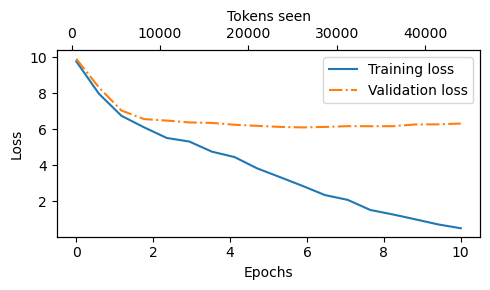

In [64]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


- 从上面的结果可以看出，模型开始时生成的是一串无法理解的单词，而到了后期，它能够产生语法上或多或少正确的句子。
- 然而，根据训练和验证集的损失，我们可以看到模型开始过拟合。
- 如果我们检查它在训练结束时写的几段文字，我们会发现自己的写作完全照搬了训练集——它只是简单地记住了训练数据。
- 稍后，我们将介绍可以一定程度上减轻这种记忆的解码策略。
- 请注意，这里的过拟合发生是因为我们有一个非常非常小的训练集，并且我们多次迭代它。
  - 这里的LLM训练主要是为了教育目的；我们主要想看到模型能够学会产生连贯的文本。
  - 我们不是花几周或几个月的时间在大量昂贵的硬件上训练这个模型，而是稍后加载预训练的权重。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-2.webp" width=350px>

## 5.3 Decoding strategies to control randomness

- 先将模型从GPU传回CPU，因为相对较小的模型推理不需要GPU。
- 使用我们在前一章中使用过的`generate_text_simple`函数（简单训练函数内部），我们可以一次生成一个单词（或标记）的新文本。
- 如第5.1.2节所解释的，下一个生成的标记是词汇表中所有标记中概率分数最大的标记对应的标记。

In [66]:
model.to("cpu")  # 将模型移至CPU
model.eval()  # 设置模型为评估模式

tokenizer = tiktoken.get_encoding("gpt2")  # 获取词元编码器
token_ids = generate_text_simple(  # 调用generate_text_simple函数生成词元
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),  # 将文本转换为词元ID
    max_new_tokens=25,  # 最大生成词元数为25
    context_size=GPT_CONFIG_124M["context_length"]  # 上下文大小为GPT_CONFIG_124M的context_length
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))  # 打印生成的文本


Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- 即使我们多次执行上面的`generate_text_simple`函数，LLM也总是生成相同的输出。
- 我们现在引入两个概念，即所谓的解码策略，来修改`generate_text_simple`：*温度缩放*和*top-k*采样。
- 这些将允许模型控制生成文本的随机性和多样性。

### 5.3.1 Temperature scaling

- 之前，我们总是使用`torch.argmax`采样最高概率的标记作为下一个标记。
- 为了增加多样性，我们可以使用`torch.multinomial(probs, num_samples=1)`从概率分布中采样下一个标记。
- 在这里，每个索引被选中的机会对应于其在输入张量中的概率。

- 这是一个关于生成下一个标记的小回顾，假设一个非常小的词汇表用于说明目的：

In [68]:
vocab = {  # 定义词汇表
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}  # 定义反向词汇表

next_token_logits = torch.tensor(  # 定义下一个词元的logits
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)  # 将logits转换为概率
next_token_id = torch.argmax(probas).item()  # 获取概率最大的词元ID
print(inverse_vocab[next_token_id])  # 打印生成的词元


forward


In [72]:
torch.manual_seed(123)  # 设置随机种子
next_token_id = torch.multinomial(probas, num_samples=1).item()  # 使用多项式分布采样
print(inverse_vocab[next_token_id])  # 打印生成的词元

toward


- 我们不是通过`torch.argmax`来确定最可能的标记，而是使用`torch.multinomial(probas, num_samples=1)`通过从softmax分布中采样来确定最可能的标记。
- 为了说明目的，让我们看看当我们使用原始的softmax概率1,000次采样下一个标记时会发生什么：

In [74]:
def print_sampled_tokens(probas): 
    torch.manual_seed(123)  # 设置随机种子
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]  # 进行1000次采样
    sampled_ids = torch.bincount(torch.tensor(sample))  # 计算每个词元的出现频率
    for i, freq in enumerate(sampled_ids):  # 遍历词元频率
        print(f"{freq} x {inverse_vocab[i]}")  # 打印词元及其出现频率
        
print_sampled_tokens(probas)  # 调用print_sampled_tokens函数

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- 我们可以通过一个称为温度缩放的概念来控制分布和选择过程。
- “温度缩放”只是一个花哨的词，意味着将logits除以一个大于0的数字。
- 大于1的温度将在应用softmax后导致更均匀分布的标记概率。
- 小于1的温度将在应用softmax后导致更尖锐或更高峰的分布。

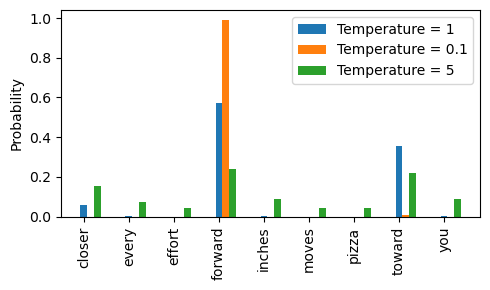

In [76]:
def softmax_with_temperature(logits, temperature):  # 定义带温度的softmax函数
    scaled_logits = logits / temperature  # 对logits进行温度缩放
    return torch.softmax(scaled_logits, dim=0)  # 返回softmax结果
temperatures = [1, 0.1, 5]  #A 定义温度列表
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]  # 对每个温度计算缩放后的概率
x = torch.arange(len(vocab))  # 定义x轴刻度
bar_width = 0.15  # 定义柱宽
fig, ax = plt.subplots(figsize=(5, 3))  # 创建图形和子图
for i, T in enumerate(temperatures):  # 遍历温度列表
    rects = ax.bar(x + i * bar_width, scaled_probas[i],  # 绘制柱状图
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')  # 设置y轴标签为“Probability”
ax.set_xticks(x)  # 设置x轴刻度
ax.set_xticklabels(vocab.keys(), rotation=90)  # 设置x轴刻度标签
ax.legend()  # 显示图例
plt.tight_layout()  # 调整子图布局
plt.show()  # 显示图形

- 我们可以看到，通过温度0.1的重新缩放导致了一个更尖锐的分布，接近torch.argmax，以至于最可能的单词几乎总是被选中：

In [78]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


- 通过温度5重新缩放的概率分布更加均匀：

In [80]:
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


- 假设LLM输入为“every effort moves you”，使用上述方法有时会产生无意义的文本，例如“every effort moves you pizza”，占4.3%（1000次中的43次）。

### 5.3.2 Top-k sampling

- 为了能够使用更高的温度来增加输出多样性并减少无意义句子的概率，我们可以将采样的标记限制在最可能的top-k个标记中：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp" width=500px>

- (请注意，为了减少视觉混乱，图中的数字被截断为小数点后两位。Softmax行中的值应该加起来等于1.0。
)

- 在代码中，我们可以这样实现：

In [82]:
top_k = 3  # 设置top-k为3
top_logits, top_pos = torch.topk(next_token_logits, top_k)  # 选择具有最大logit值的词元
print("Top logits:", top_logits)  # 打印最大logit值
print("Top positions:", top_pos)  # 打印最大logit值的位置

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [84]:
new_logits = torch.where(  # 使用where函数更新logits
    condition=next_token_logits < top_logits[-1],  #A 确定小于top 3最小值的logits
    input=torch.tensor(float('-inf')),  #B 将这些较低的logits赋值为-inf
    other=next_token_logits  #C 其他词元保留原始logits
)
print(new_logits)  # 打印更新后的logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [86]:
topk_probas = torch.softmax(new_logits, dim=0)  # 对更新后的logits应用softmax函数
print(topk_probas)  # 打印top-k概率

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function

- 前两个小节介绍了温度采样和top-k采样。
- 让我们使用这两个概念来修改我们之前用来通过LLM生成文本的`generate_simple`函数，创建一个新的`generate`函数：

In [88]:
def generate(model, idx, max_new_tokens, context_size,  # 定义生成函数
             temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):  #A 遍历最大新词元数
        idx_cond = idx[-context_size:]  # 获取上下文
        with torch.no_grad():  # 禁用梯度计算
            logits = model(idx_cond)  # 获取模型的logits
            logits = logits[:, -1, :]  # 只关注最后一个时间步的logits
        if top_k is not None:  #B 在新部分中，使用top-k采样
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,  #A 确定小于top 3最小值的logits
                torch.tensor(float('-inf')).to(logits.device),  #B 将这些较低的logits赋值为-inf
                logits  #C 其他词元保留原始logits
            )

        if temperature > 0.0:  #C 这是我们应用温度缩放的新部分
            logits = logits / temperature  # 对logits进行温度缩放
            probs = torch.softmax(logits, dim=-1)  # 应用softmax函数
            idx_next = torch.multinomial(probs, num_samples=1)  # 使用多项式函数进行采样
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  #D 在禁用温度缩放时执行贪婪选择
        if idx_next == eos_id:  #E 如果遇到序列结束词元且指定了eos_id，则提前终止生成
            break
        idx = torch.cat((idx, idx_next), dim=1)  # 将新词元添加到索引序列中
    return idx  # 返回索引序列

In [90]:
torch.manual_seed(123)  # 设置随机种子
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),  # 将文本转换为词元ID并移动到设备
    max_new_tokens=15,  # 最大新词元数为15
    context_size=GPT_CONFIG_124M["context_length"],  # 上下文大小
    top_k=25,  # top-k值为25
    temperature=1.4  # 温度值为1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))  # 打印生成的文本

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


## 5.4 Loading and saving model weights in PyTorch

- 训练LLMs在计算上很昂贵，因此能够保存和加载LLM权重至关重要。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-3.webp" width=400px>

- PyTorch中推荐的方式是保存模型权重，即所谓的`state_dict`，通过将`torch.save`函数应用于`.state_dict()`方法来实现：

In [92]:
torch.save(model.state_dict(), "model.pth")  # 保存模型权重到model.pth文件

- 然后，我们可以将模型权重加载到一个新的`GPTModel`模型实例中，如下所示：

In [94]:
model = GPTModel(GPT_CONFIG_124M)  # 初始化新模型实例
model.load_state_dict(torch.load("model.pth"))  # 加载保存的模型权重
model.eval()  # 设置模型为评估模式

C:\Users\xin123456\AppData\Local\Temp\ipykernel_3036\1053747252.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))  # 加载保存的模型

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- 使用像Adam或AdamW这样的自适应优化器而不是常规的SGD来训练LLMs是很常见的。
- 这些自适应优化器为每个模型权重存储额外的参数，因此，如果我们计划稍后继续预训练，保存它们也是有意义的：

In [96]:
torch.save({  # 保存模型和优化器的状态字典
    "model_state_dict": model.state_dict(),  # 模型状态字典
    "optimizer_state_dict": optimizer.state_dict(),  # 优化器状态字典
}, "model_and_optimizer.pth")  # 保存到model_and_optimizer.pth文件

In [98]:
checkpoint = torch.load("model_and_optimizer.pth")  # 加载保存的检查点
model = GPTModel(GPT_CONFIG_124M)  # 初始化新模型实例
model.load_state_dict(checkpoint["model_state_dict"])  # 加载模型状态字典
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)  # 初始化优化器
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])  # 加载优化器状态字典
model.train()  # 设置模型为训练模式

C:\Users\xin123456\AppData\Local\Temp\ipykernel_3036\3763583658.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth")  # 加载保

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.5 Loading pretrained weights from OpenAI

In [100]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.18.0
tqdm version: 4.66.4


In [102]:
from gpt_download import download_and_load_gpt2

In [104]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 68.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:05<00:00, 176kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 63.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [2:15:46<00:00, 61.1kiB/s]  
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.56MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:07<00:00, 63.0kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 420kiB/s] 


In [125]:
print("Settings:", settings)  # 打印设置
print("Parameter dictionary keys:", params.keys())  # 打印参数字典键

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


- settings和params都是Python字典:
    - settings字典存储LLM架构设置，类似于我们手动定义的GPT_CONFIG_124M设置。
    - params字典包含实际的权重张量。
- 请注意，我们只打印了字典键，因为打印权重内容会占用太多屏幕空间，但我们可以通过print(params)打印整个字典或通过相应的字典键选择单个张量来检查这些权重张量，例如，嵌入层权重：

In [127]:
print(params["wte"])  # 打印词元嵌入权重张量
print("Token embedding weight tensor dimensions:", params["wte"].shape)  # 打印词元嵌入权重张量的维度

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 我们通过`download_and_load_gpt2(model_size=“124M”, …)`设置下载并加载了最小的GPT-2模型的权重。
- 请注意，OpenAI还分享了更大模型的权重：“355M”、“774M”和“1558M”。这些不同大小的GPT模型的总体架构是相同的。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-sizes.webp?timestamp=123" width=500px>

- 上面，我们已经将1.24亿参数的GPT-2模型权重加载到了Python中，但是我们仍然需要将它们转移到我们的`GPTModel`实例中。
- 首先，我们初始化一个新的 `GPTModel` 实例。
- 请注意，原始的GPT模型在多头注意力模块中为查询（query）、键（key）和值（value）矩阵的线性层初始化了带有偏置向量的，这并不是必需的或推荐的；然而，为了能够正确加载权重，在我们的实现中，我们也必须通过将`qkv_bias`设置为`True`来启用这些偏置。
- 我们也在使用原始GPT-2模型所采用的`1024`个token的上下文长度。

In [129]:
model_configs = {  # 定义模型配置字典
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"  # 选择模型名称
NEW_CONFIG = GPT_CONFIG_124M.copy()  # 复制原始配置
NEW_CONFIG.update(model_configs[model_name])  # 更新配置为选定模型的配置
NEW_CONFIG.update({"context_length": 1024})  # 更新上下文长度为1024
NEW_CONFIG.update({"qkv_bias": True})  # 启用偏置向量
gpt = GPTModel(NEW_CONFIG)  # 使用更新的配置初始化GPT模型
gpt.eval()  # 设置模型为评估模式

gpt = GPTModel(NEW_CONFIG)  # 使用更新的配置初始化GPT模型
gpt.eval()  # 设置模型为评估模式

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

- 接下来的任务是将OpenAI的权重分配到我们`GPTModel`实例中相应的权重张量。

In [131]:
def assign(left, right):  # 定义assign函数
    if left.shape != right.shape:  # 如果形状不匹配
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")  # 抛出错误
    return torch.nn.Parameter(torch.tensor(right))  # 返回右张量作为可训练参数

In [135]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型加载正确，我们就可以使用先前的`generate`函数来生成新文本：

In [137]:
torch.manual_seed(123)  # 设置随机种子
token_ids = generate(  # 生成新文本
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))  # 打印输出文本

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


## Summary

- 当LLM生成文本时，它们一次输出一个词元。
- 默认情况下，下一个词元是通过将模型输出转换为概率分数并从词汇表中选择对应于最高概率分数的词元生成的，这被称为“贪婪解码”。
- 使用概率采样和温度缩放，我们可以影响生成文本的多样性和连贯性。
- 训练和验证集的损失可用于评估LLM在训练期间生成的文本质量。
- 预训练LLM涉及更改其权重以最小化训练损失。
- LLM的训练循环本身是深度学习中的标准程序，使用传统的交叉熵损失和AdamW优化器。
- 在大型文本语料库上预训练LLM是耗时且资源密集的，因此我们可以加载OpenAI公开可用的权重，作为我们自己在大型数据集上预训练模型的替代方案。